In [23]:
import numpy as np
np.random.seed(42)
import time
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
print("cv2 version:",cv2.__version__)
def fixColor(image):
    return(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

cv2 version: 4.5.1


In [24]:
labels_file= "/cxldata/projects/yolov4/coco.names"
LABELS = open(labels_file).read().strip().split("\n")
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")
LABELS[:5]

['person', 'bicycle', 'car', 'motorbike', 'aeroplane']

In [25]:
weights="/cxldata/projects/yolov4/yolov4.weights"
config="/cxldata/projects/yolov4/yolov4.cfg"
net = cv2.dnn.readNetFromDarknet(config, weights)
ln = net.getLayerNames()
print (len(ln), ln )
net.getUnconnectedOutLayers()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
print (ln)

379 ['conv_0', 'bn_0', 'mish_1', 'conv_1', 'bn_1', 'mish_2', 'conv_2', 'bn_2', 'mish_3', 'identity_3', 'conv_4', 'bn_4', 'mish_5', 'conv_5', 'bn_5', 'mish_6', 'conv_6', 'bn_6', 'mish_7', 'shortcut_7', 'conv_8', 'bn_8', 'mish_9', 'concat_9', 'conv_10', 'bn_10', 'mish_11', 'conv_11', 'bn_11', 'mish_12', 'conv_12', 'bn_12', 'mish_13', 'identity_13', 'conv_14', 'bn_14', 'mish_15', 'conv_15', 'bn_15', 'mish_16', 'conv_16', 'bn_16', 'mish_17', 'shortcut_17', 'conv_18', 'bn_18', 'mish_19', 'conv_19', 'bn_19', 'mish_20', 'shortcut_20', 'conv_21', 'bn_21', 'mish_22', 'concat_22', 'conv_23', 'bn_23', 'mish_24', 'conv_24', 'bn_24', 'mish_25', 'conv_25', 'bn_25', 'mish_26', 'identity_26', 'conv_27', 'bn_27', 'mish_28', 'conv_28', 'bn_28', 'mish_29', 'conv_29', 'bn_29', 'mish_30', 'shortcut_30', 'conv_31', 'bn_31', 'mish_32', 'conv_32', 'bn_32', 'mish_33', 'shortcut_33', 'conv_34', 'bn_34', 'mish_35', 'conv_35', 'bn_35', 'mish_36', 'shortcut_36', 'conv_37', 'bn_37', 'mish_38', 'conv_38', 'bn_38', '

(608, 608, 3)
Shape of blob (1, 3, 608, 608)


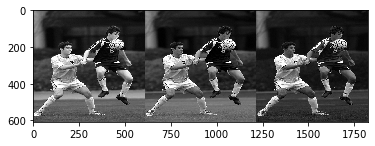

In [26]:
img=cv2.imread("/cxldata/projects/yolov4/soccer.jpg")
img=cv2.resize(img,(608,608))
print(img.shape)
(H, W) = img.shape[:2]
plt.imshow(fixColor(img))
blob = cv2.dnn.blobFromImage(img, 1 / 255.0, (608, 608), swapRB=True, crop=False)
print("Shape of blob", blob.shape)
split_blob=np.hstack([ blob[0, 0, :, :],blob[0, 1, :, :], blob[0, 2, :, :],])
plt.imshow(fixColor(split_blob))

In [38]:
net.setInput(blob)
t0 = time.time()
layerOutputs = net.forward(ln)
t = time.time()
print('time=', t-t0)
(np.array(layerOutputs)).shape

time= 1.2605586051940918


(3,)

In [41]:
boxes = []
confidences = []
classIDs = []
for output in layerOutputs:
    print ("Shape of each output", output.shape)
    # loop over each of the detections
    for detection in output:
        # extract the class ID and confidence (i.e., probability)
        # of the current object detection
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]

        # filter out weak predictions by ensuring the detected
        # probability is greater than the minimum probability
        if confidence > 0.3:
            # scale the bounding box coordinates back relative to
            # the size of the image, keeping in mind that YOLO
            # actually returns the center (x, y)-coordinates of
            # the bounding box followed by the boxes' width and
            # height
            box = detection[0:4] * np.array([W, H, W, H])
            (centerX, centerY, width, height) = box.astype("int")

            # use the center (x, y)-coordinates to derive the top
            # and and left corner of the bounding box
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))

            # update our list of bounding box coordinates,
            # confidences, and class IDs
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            classIDs.append(classID)
            print (LABELS[classID], detection[4], confidence)
print (len(boxes))
idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.3)
print (len(idxs))

Shape of each output (17328, 85)
sports ball 0.9116492 0.90988046
sports ball 0.93582696 0.9307697
Shape of each output (4332, 85)
sports ball 0.9963799 0.99579364
sports ball 0.99670726 0.9954545
sports ball 0.9961105 0.99263036
Shape of each output (1083, 85)
sports ball 0.9960573 0.99452233
person 0.9149836 0.9148787
person 0.9186291 0.9185599
person 0.9891433 0.9891228
person 0.98990065 0.9898779
person 0.5279726 0.5277281
person 0.55256116 0.55226564
person 0.8187046 0.81856424
person 0.78427434 0.78412884
person 0.9692143 0.9690731
person 0.96856123 0.968457
person 0.978408 0.9783869
person 0.98149246 0.98147
person 0.5947928 0.5946748
person 0.5611462 0.56101215
person 0.36454174 0.3641918
person 0.45565358 0.4552634
person 0.77969605 0.77929246
person 0.7788326 0.7784597
24
3


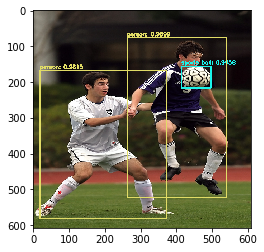

In [42]:
# ensure at least one detection exists
if len(idxs) > 0:
    # loop over the indexes we are keeping
    for i in idxs.flatten():
        # extract the bounding box coordinates
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])

        # draw a bounding box rectangle and label on the frame
        color = [int(c) for c in COLORS[classIDs[i]]]
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        text = "{}: {:.4f}".format(LABELS[classIDs[i]],
            confidences[i])
        cv2.putText(img, text, (x, y - 5),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
plt.imshow(fixColor(img))        